# InfoGAN

In [1]:
import tensorflow as tf
import numpy as np

# Download & Load MNIST Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def fully_connected_layer(x, output_size, initializer=tf.random_uniform_initializer(), activation=tf.nn.relu, count=0):
    w = tf.get_variable('w' + str(count), [x.get_shape()[1], output_size], initializer=initializer)
    b = tf.get_variable('b' + str(count), [output_size], initializer=initializer, dtype=tf.float32, trainable=True)
    
    print(w.name, b.name)
    
    l = tf.nn.bias_add(tf.matmul(x, w), b)
    
    return activation(l) if activation!=None else l, l, w, b


In [5]:
class ModelMaker(object):
    def __init__(self, layer_sizes):
        # Fully Connected Layers
        self.fcl_sizes = layer_sizes

        
    def create_layers(self, x, initializer=tf.truncated_normal_initializer, initializer_params={'dtype': tf.float32, 'stddev': 1e-1},\
                      name='noname', reuse=False):
        if not reuse:
            self.parameters = []

        last_layer = x
        last_size = int(np.prod(last_layer.get_shape()[1:]))

        with tf.variable_scope(name, reuse=reuse) as scope:
            # Generate Dense Layer
            for layer_count, ((layer_size, param_dict), dropout_use, constant_dropout, dropout_rate) in enumerate(self.fcl_sizes):
                last_layer, l, w, b = fully_connected_layer(x=last_layer, output_size=layer_size, \
                                                            initializer=initializer(**initializer_params), count=layer_count, **param_dict)
                
                if not reuse:
                    self.parameters = self.parameters + [w, b]

                if dropout_use:
                    if constant_dropout:
                        last_layer = tf.nn.dropout(last_layer, dropout_rate)
                    else:
                        last_layer = tf.nn.dropout(last_layer, self.dropout_rates[dropout_rate])

                        
                setattr(self, 'dense_%d_%s' % (layer_count+1, name), last_layer)

        self.last_layer = last_layer

In [6]:
# Reference : https://github.com/GunhoChoi/LSGAN_TF/blob/master/LSGAN/LSGAN_TF.ipynb
def LeakyReLU(x, leak=0.2, name='LeakyReLU'):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [7]:
from PIL import Image
def ArrayToImage(arr):
    
    size = np.sqrt(arr.shape[0]).astype(int)
    arr = arr.reshape(size, size)
    
    img = Image.fromarray(np.uint8(arr))
    return img

from IPython import display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import time

def DisplayHorizontal(images, header=None, width="100%", figsize=(20, 20), fontsize=20, depth=1):
    num_images = len(images)
    
    fig = plt.figure(figsize=figsize)
    for i in range(num_images):
        image = images[i]
        
        fig.add_subplot(depth, num_images/depth, i+1)
        plt.axis('off')
        if header != None:
            plt.title(header[i], fontsize=fontsize)
        plt.imshow(image, cmap='Greys_r', interpolation='nearest')

In [8]:
from sklearn.preprocessing import LabelBinarizer

In [9]:
lb = LabelBinarizer()
lb.fit(range(10))

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

# Implement Option

In [10]:
z_var_dim = 100
z_category = 10
z_weight = 2

z_size = z_var_dim + z_category + z_weight

img_size = 784

generator_layer_shape = (
    ((128, {}), False, None, None),
    ((256, {}), False, None, None),
    ((img_size, {'activation': tf.nn.tanh}), False, None, None),
)

discriminator_layer_shape = (
    ((256, {'activation': LeakyReLU}), False, None, None),
    ((128, {'activation': LeakyReLU}), False, None, None),
    #((1, {'activation': tf.nn.sigmoid}), False, None, None),
)

### Train Option

In [11]:
epoch_size = 5000
batch_size = 512
d_train_epoch = 4
g_train_epoch = 1

# Implement Variable & Model

In [12]:
with tf.device('/gpu:0'):            
    G = ModelMaker(generator_layer_shape)
    D = ModelMaker(discriminator_layer_shape)
        
    Z_Var = tf.placeholder(tf.float32, [None, z_var_dim])
    Z_Category = tf.placeholder(tf.float32, [None, z_category])
    Z_Weight = tf.placeholder(tf.float32, [None, z_weight])
    
    Z = tf.concat([Z_Var, Z_Category, Z_Weight], 1)
    #Z = tf.concat([Z_Var, Z_Category], 1)

    G.create_layers(Z, name='Generator')
    X_Fake = G.last_layer
    X_Real = tf.placeholder(tf.float32, [None, img_size])
    Y = tf.placeholder(tf.float32, shape=[None, z_category])
    
    # Fake Data
    D.create_layers(X_Fake, name='Discriminator')
    FC_Fake = D.last_layer
    with tf.variable_scope('Discriminator'):
        Y_Fake, Y_Fake_Logits = fully_connected_layer(FC_Fake, 1, activation=tf.nn.sigmoid, count='output')[:2]
        Y_Fake_Category = fully_connected_layer(FC_Fake, z_category, activation=LeakyReLU, count='category')[0]
        Y_Fake_Weight = fully_connected_layer(FC_Fake, z_weight, activation=tf.nn.tanh, count='weight')[0]
        
    # Real Data
    D.create_layers(X_Real, name='Discriminator', reuse=True)
    FC_Real = D.last_layer    
    with tf.variable_scope('Discriminator', reuse=True):
        Y_Real, Y_Real_Logits = fully_connected_layer(FC_Real, 1, activation=tf.nn.sigmoid, count='output')[:2]
        Y_Real_Category = fully_connected_layer(FC_Real, z_category, activation=LeakyReLU, count='category')[0]
        Y_Real_Weight = fully_connected_layer(FC_Real, z_weight, activation=tf.nn.tanh, count='weight')[0]
    
    Optimizer_D = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=5e-1)
    Optimizer_G = tf.train.AdamOptimizer(learning_rate=1e-3, beta1=5e-1)
    
    Loss_D = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Y_Real_Logits, labels=tf.ones_like(Y_Real)) + \
        tf.nn.sigmoid_cross_entropy_with_logits(logits=Y_Fake_Logits, labels=tf.zeros_like(Y_Fake)))
    Loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Y_Fake_Logits, labels=tf.ones_like(Y_Fake)))
    
    Loss_D_Category = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=Y, logits=Y_Real_Category))
    Loss_G_Category = tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=Z_Category, logits=Y_Fake_Category))
    
    Loss_G_Weight = tf.losses.mean_squared_error(Y_Fake_Weight, Z_Weight)
    
    Loss_D_Total = Loss_D + Loss_D_Category
    Loss_G_Total = Loss_G + Loss_G_Category + Loss_G_Weight
    
    Param_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')
    Param_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
    
    Grad_D = Optimizer_D.compute_gradients(Loss_D_Total, Param_D)
    Grad_G = Optimizer_G.compute_gradients(Loss_G_Total, Param_G)
    
    Train_D = Optimizer_D.apply_gradients(Grad_D)
    Train_G = Optimizer_G.apply_gradients(Grad_G)

Generator/w0:0 Generator/b0:0
Generator/w1:0 Generator/b1:0
Generator/w2:0 Generator/b2:0
Discriminator/w0:0 Discriminator/b0:0
Discriminator/w1:0 Discriminator/b1:0
Discriminator/woutput:0 Discriminator/boutput:0
Discriminator/wcategory:0 Discriminator/bcategory:0
Discriminator/wweight:0 Discriminator/bweight:0
Discriminator/w0:0 Discriminator/b0:0
Discriminator/w1:0 Discriminator/b1:0
Discriminator/woutput:0 Discriminator/boutput:0
Discriminator/wcategory:0 Discriminator/bcategory:0
Discriminator/wweight:0 Discriminator/bweight:0


# Train & Show Result

In [13]:
z_sample = np.random.normal(0, 1, size=(10, z_var_dim)).astype(np.float32)
z_label = lb.transform(range(10))
z_weight = np.random.random(size=[10, z_weight]) * 2 - 1

In [14]:
z_sample = np.concatenate([z_sample, z_label, z_weight], axis=1)

In [15]:
display_epoch = 5

In [16]:
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.1, allow_growth=True)))

tf.global_variables_initializer().run(session=sess)

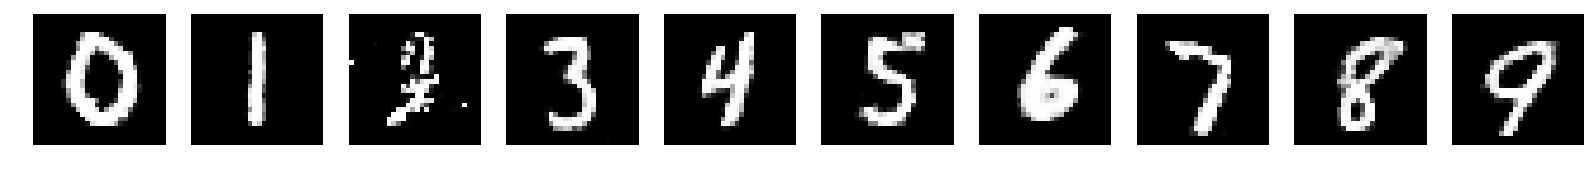

Epoch : 4996, loss_d & total : 0.4634 & 0.4674, loss_g & total : 4.1964 & 5.3029
Epoch : 4997, loss_d & total : 0.4605 & 0.4632, loss_g & total : 4.2262 & 5.3345
Epoch : 4998, loss_d & total : 0.4810 & 0.4916, loss_g & total : 4.2020 & 5.3016
Epoch : 4999, loss_d & total : 0.5021 & 0.5148, loss_g & total : 4.0623 & 5.1783


In [17]:
for i in range(epoch_size):
    ld = []
    ld_total = []
    lg = []
    lg_total = []
    
    count = int(mnist.train.num_examples / batch_size)
    for j in range(count):
        batch_train, batch_target = mnist.train.next_batch(batch_size)
        batch_train = batch_train.astype(np.float32) * 2 - 1
        
        batch_z = np.random.normal(0, 1, size=(batch_size, z_var_dim)).astype(np.float32)
        batch_z_category = lb.transform(np.random.randint(0, 10, size=batch_size))
        batch_z_weight = np.random.random(size=[batch_size, 2]) * 2 - 1
        
        # Discriminator Train
        for _ in range(d_train_epoch):
            _, loss_d, loss_d_total = sess.run([Train_D, Loss_D, Loss_D_Total], \
                                 feed_dict={X_Real: batch_train, Y: batch_target, \
                                            Z_Var: batch_z, Z_Category: batch_z_category, Z_Weight: batch_z_weight})
            ld += [loss_d]
            ld_total += [loss_d_total]

        # Generator Train
        for _ in range(g_train_epoch):
            _, loss_g, loss_g_total = sess.run([Train_G, Loss_G, Loss_G_Total], \
                                 feed_dict={X_Real: batch_train, \
                                            Z_Var: batch_z, Z_Category: batch_z_category, Z_Weight: batch_z_weight})
            lg += [loss_g]
            lg_total += [loss_g_total]
            
    print('Epoch : %d, loss_d & total : %.4f & %.4f, loss_g & total : %.4f & %.4f' % \
          (i, np.mean(ld), np.mean(ld_total), np.mean(lg), np.mean(lg_total)))
    
    gen_mnist = sess.run(X_Fake, feed_dict={Z: z_sample})
    if i % display_epoch == 0:
        display.clear_output(wait=True)
        DisplayHorizontal([ArrayToImage((x * 0.5 + 0.5) * 255) for x in gen_mnist])
        display.display(plt.gcf())
        plt.close()

# TEST

In [22]:
new_z_label = lb.transform([1] * 10)
#new_z_label = lb.transform(range(10))

new_z_label = np.zeros([10, 10])
for i in range(10):
    new_z_label[i][3] = np.linspace(1, 0, 10)[i]
    new_z_label[i][8] = np.linspace(0, 1, 10)[i]

In [53]:
new_z_weight = np.zeros([10, 2])
for i in range(10):
    new_z_weight[i][0] = np.linspace(-1, 1, 10)[i]
    new_z_weight[i][1] = np.linspace(-1, 1, 10)[i]

In [54]:
new_z_var = np.random.normal(0, 1, size=(10, z_var_dim)).astype(np.float32)    

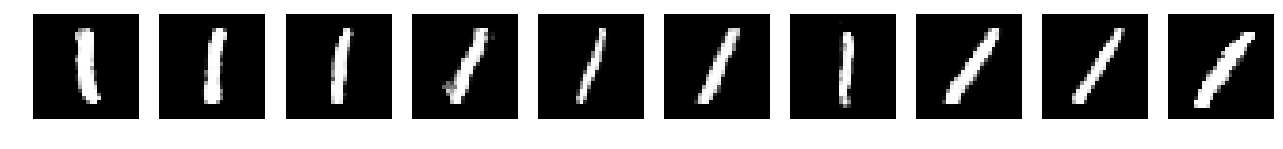

In [55]:
new_z_sample = np.concatenate([new_z_var, new_z_label, new_z_weight], axis=1)

gen_mnist = sess.run(X_Fake, feed_dict={Z: new_z_sample})
DisplayHorizontal([ArrayToImage((x * 0.5 + 0.5) * 255) for x in gen_mnist], depth=1, figsize=(16, 4*2))
display.display(plt.gcf())